**데이터 불러오기**

In [1]:
import pandas as pd
data = pd.read_csv('./data/000660.csv')

**데이터 칼럼명 영어로 바꾸기**

In [2]:
data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Rate']

**데이터 날짜 형식 바꾸기**

In [3]:
Date = data['Date'].apply(lambda x : x.replace('년 ','-'))\
                   .apply(lambda x : x.replace('월 ','-'))\
                   .apply(lambda x : x.replace('일',''))
data['Date'] = Date

**데이터에 들어있는 숫자형식 바꾸기 (, 제거)**

In [4]:
import numpy as np
Close = data['Close'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Close'] = Close

Open = data['Open'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Open'] = Open

High = data['High'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['High'] = High

Low = data['Low'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Low'] = Low

**데이터 순서 뒤집기**

In [5]:
data = data[::-1]

**Index 날짜로 지정하기**

In [6]:
data = data.set_index('Date')

**필요없는 변수(Volumne, Rate) 제거하기**

In [7]:
del data['Volume']
del data['Rate']

**중간결과**

In [8]:
data

,Close,Open,High,Low
Date,,,,
2011-08-23,17050.0,16200.0,17050.0,16000.0
2011-08-24,16250.0,17200.0,17550.0,15900.0
2011-08-25,17300.0,16900.0,17700.0,16700.0
2011-08-26,17950.0,17050.0,17950.0,16950.0
2011-08-29,19450.0,18550.0,19600.0,18350.0
...,...,...,...,...
2020-02-13,102000.0,100500.0,103500.0,100500.0
2020-02-14,104500.0,101500.0,105000.0,101000.0
2020-02-16,104500.0,104500.0,104500.0,104500.0


**데이터프레임 어레이로 변경하기**

In [9]:
data = np.array(data)

**10년간 000660 종가 그래프**

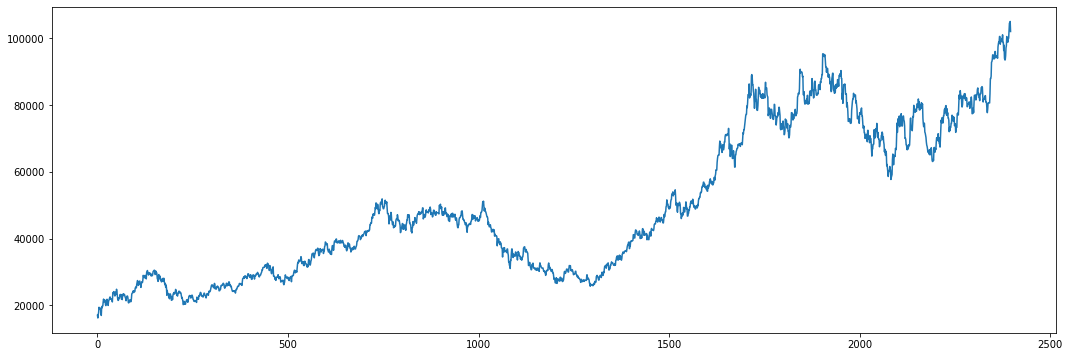

In [10]:
close = data[:,0]
from matplotlib import pyplot as plt
plt.figure(figsize=(18,6))
plt.plot(range(len(close)), close)
plt.show()

**최근 1년간 000660 종가 그래프**

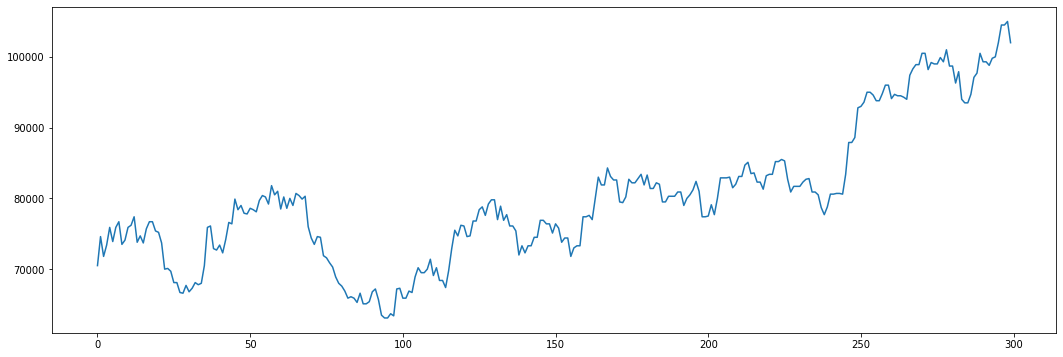

In [11]:
close = data[:,0]
from matplotlib import pyplot as plt
plt.figure(figsize=(18,6))
plt.plot(range(300), close[-300:])
plt.show()

**데이터 정규화하기**

In [12]:
mean = data[:1700].mean(axis=0)
data -= mean
std = data[:1700].std(axis=0)
data /= std

**시계열 데이터와 타깃을 반환하는 제네레이터 함수**

In [13]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128., step=6) : 
    
    if max_index is None : 
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while True : 
        
        if shuffle : 
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else : 
            if i + batch_size >= max_index :
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows) : 
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        
        yield samples, targets

**훈련, 검증, 테스트 제네레이터 준비하기**

In [14]:
lookback = 5
step = 1
delay = 1
batch_size = 36

train_gen = generator(data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 1700,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)
val_gen = generator(data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 1701,
                    max_index = 2000,
                    shuffle = False,
                    step = step,
                    batch_size = batch_size)
test_gen = generator(data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 2001,
                    max_index = None,
                    shuffle = False,
                    step = step,
                    batch_size = batch_size)

val_steps = (2000 - 1701 - lookback) // batch_size

test_steps = (len(data) - 2001 - lookback) // batch_size

**상식수준의 기준점 (Random Walk)**

In [15]:
def evaluate_naive_method() : 
    batch_maes = []
    for step in range(val_steps) : 
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(abs(preds  - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.18189018290633957


In [16]:
close_mae = 0.18189018290633957 * std[0]
close_mae

2099.257262423826

**완전 연결 모델을 훈련하고 평가하기**

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Using TensorFlow backend.






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                672       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0850 - val_loss: 0.1714
Epoch 2/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0792 - val_loss: 0.1734
Epoch 3/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0781 - val_loss: 0.1702
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0764 - val_loss: 0.1976
E

**결과 그래프**

<Figure size 432x288 with 0 Axes>

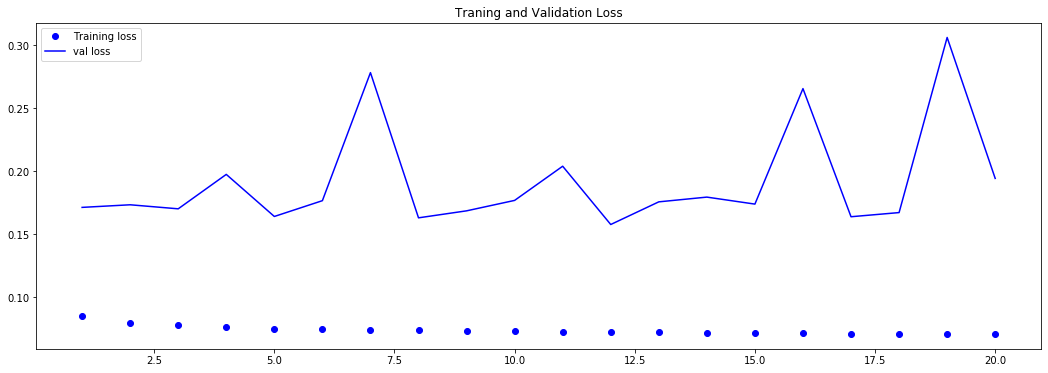

In [18]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.figure(figsize=(18,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='val loss')
plt.title('Traning and Validation Loss')
plt.legend()
plt.show()

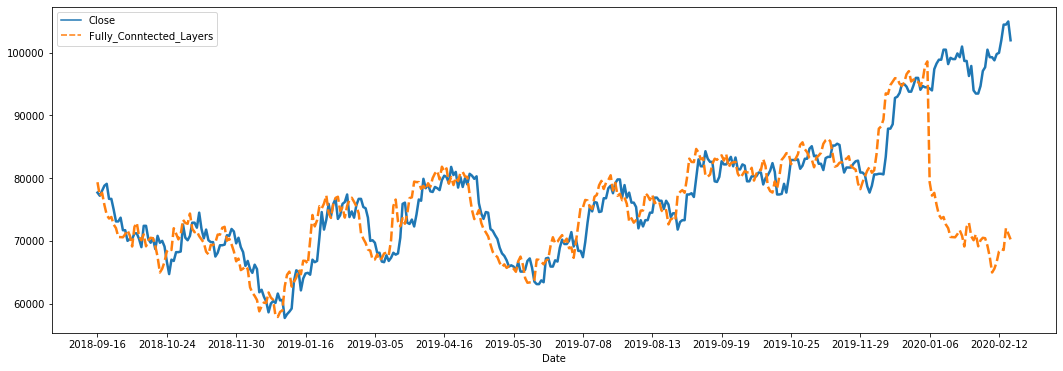

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
result = pd.DataFrame(model.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
result.columns = ['Fully_Conntected_Layers']

import pandas as pd
data = pd.read_csv('./data/000660.csv')
data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Rate']
Date = data['Date'].apply(lambda x : x.replace('년 ','-'))\
                   .apply(lambda x : x.replace('월 ','-'))\
                   .apply(lambda x : x.replace('일',''))
data['Date'] = Date
import numpy as np
Close = data['Close'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Close'] = Close
Open = data['Open'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Open'] = Open
High = data['High'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['High'] = High
Low = data['Low'].apply(lambda x : x.replace(',','')).apply(lambda x : np.float(x))
data['Low'] = Low
data = data[::-1]
data = data.set_index('Date')
del data['Volume']
del data['Rate']


import pandas as pd
tttt = data[2001:]
tttt = tttt['Close']
tttt = tttt.reset_index()
tttt = pd.concat([tttt,result], axis=1)
tttt = tttt.set_index('Date')

plt.figure(figsize=(18,6))
ax = sns.lineplot(data=tttt, palette="tab10", linewidth=2.5)
ax.set(xticks = tttt.index[0::30])
plt.show()

In [29]:
tttt_2 = tttt
tttt_2['Close_shift'] = tttt_2['Close'].shift(-1)
tttt_2['FCL_shift'] = tttt_2['Fully_Conntected_Layers'].shift(-1)
tttt_2['Close_UD'] = tttt_2['Close_shift'] - tttt_2['Close']
tttt_2['FCL_UD'] = tttt_2['FCL_shift'] - tttt_2['Fully_Conntected_Layers']
tttt_2['TRUE'] = tttt_2['Close_UD'].apply(lambda x : 1 if x > 0 else -1)
tttt_2['PRED'] = tttt_2['FCL_UD'].apply(lambda x : 1 if x > 0 else -1)
tttt_2 = tttt_2[['Close', 'Fully_Conntected_Layers', 'TRUE', 'PRED']]
tttt_2['OX'] = tttt_2['TRUE'] - tttt_2['PRED']
tttt_2['ACC'] = tttt_2['OX'].apply(lambda x : 1 if x == 0 else -1)
print('Test Accuracy = {:.2f}%' .format(100 * np.sum(tttt_2.ACC) / 396))

Test Accuracy = 5.56%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
tttt_2.TRUE.value_counts()

-1    220
 1    176
Name: TRUE, dtype: int64

In [31]:
tttt_2.PRED.value_counts()

 1    201
-1    195
Name: PRED, dtype: int64

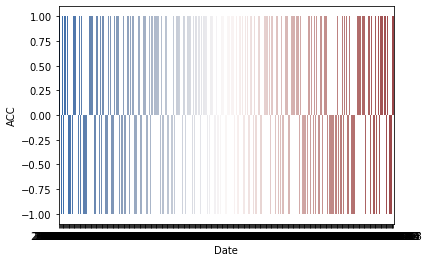

In [35]:
sns.barplot(x=tttt_2.index, y=tttt_2.ACC, palette="vlag")